# Modelo LDA
La técnica LDA se apoya en la [Distribución  a priori de Dirichlet](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_de_Dirichlet) y en el concepto de [Bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model).

A partir de un conjunto de observaciones, como son las palabras por las que está compuesta un documento, con LDA se puedan inferir otros datos no observados, es decir, extraer información aparentemente oculta. Un ejemplo son los tópicos subyacentes a un documento.

Como resultado se obtiene una serie de matrices dispersas, con muchos ceros entre sus elementos, que representan la distribución en tópicos del conjunto de documentos además de la distribución de palabras dentro de cada tópico.

Para aplicar LDA se uso de la implementación del paquete Gensim. Este algoritmo realiza una reducción de dimensionalidad, a partir del cual se realiza un agrupamientos de palabras que pertenecen al mismo tópico. Los tópicos producidos por el modelo son *clusters* de palabras similares.


In [1]:
%matplotlib inline

import spacy
import pickle
from utils import read_file, get_words_and_lemma, create_counter_word_vector
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#parametrización
TEXT_FILE = 'lavoztextodump.txt'	# Text to be processed
ENCODING = 'utf8'
MIN_FREQUENCY = 80	# Min word frequency to be considered
MIN_WORDS_COUNT_IN_SENT=10
POS_TAG= ['PROPN', 'ADJ', 'NOUN', 'VERB', 'ADV']
NUM_TOPICS=30

In [3]:
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
nlp.max_length = 34886712

dataset = read_file(TEXT_FILE, ENCODING)
#doc = nlp(dataset)

filename = "trained/doc_npl_la_voz.pickle"
#fileObj = open(filename, 'wb')
#pickle.dump(doc, fileObj)
#fileObj.close()

with open(filename, 'rb') as f:
    doc = pickle.load(f)

## Pre procesamiento

Se realizan los siguientes procesamientos:
1. Eliminación de *stop words*
2. Lematización utilizando Spacy
3. Eliminación de las palabras menos frecuentes
4. Identificación de biagramas y trigramas: los bigramas son dos palabras que aparecen juntas con frecuencia en el documento y los trigramas son tres palabras que aparecen juntas con frecuencia en el documento. Para hacer esto se uso Phrases de Gensim.
5. Eliminación de palabras no alfanuméricas
6. Solo se consideran palabras cuyo *part-of-speech* son un nombre propio, un adjetivo, un adverbio, un sustantivo o un verbo. [Ver *Universal POS tags*](https://universaldependencies.org/docs/u/pos/)

In [4]:
#identificación de las frecuencias de las palabras
words, words_lemma = get_words_and_lemma(doc, MIN_WORDS_COUNT_IN_SENT, POS_TAG)

counts = create_counter_word_vector(words_lemma)

sents = [sent for sent in doc.sents if len(sent) > MIN_WORDS_COUNT_IN_SENT] #Se eliminan oraciones con menos de 10 palabras

#se obtiene un array con las oraciones (en formato texto), cuyas palabras han pasado por un proceso de lematización y filtrado
doc_list = []
for indexsent, sent in enumerate(sents):
    resultArray = []
    for word in sent:
        if word.is_alpha and not word.is_stop and word.pos_ in POS_TAG and counts[word.lemma_] > MIN_FREQUENCY:
            resultArray.append(word.lemma_)
    if len(resultArray) > 0:
        doc_list.append(resultArray)


#Se convierte cada oración en una lista de palabras, eliminando las puntuaciones y caracteres innecesarios
#para esto usamos simple_preprocess () de Gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(doc_list))

#print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[3]]])

# Define functions for bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Bigrams
data_lemmatized = make_trigrams(data_words_bigrams)

#Filtrado de oraciones con minima cantidad de palabras
#data_lemmatized = []
#for temp in data_lemmatized_temp:
#    if len(temp) > 5:
#        data_lemmatized.append(temp)
#print(data_lemmatized[:1])


## Crear diccionario y corpus

Las dos principales entradas para un modelo LDA son el diccionario (id2word) y el corpus.

Gensim va a crear identificadores únicos para cada palabra en el documento. Este identificador es usado como entrada por el modelo LDA.

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('martinez', 1), ('pareja', 1), ('sostener', 1)]]

## Construir modelos LDA con diferentes números de tópicos

Construimos diferentes modelos LDA. Para ello simplemente creamos un objeto LdaModel de la librería Gensim pasándole como argumento el corpus y el diccionario y le indicamos adicionalmente los siguientes parámetros:
- num_topics: número de tópicos.
- random_state: parámetro para controlar la aleatoriedad del proceso de entrenamiento y que nos devuelva siempre los mismos resultados.
- chunksize: número de documentos para cargar en memoria a la vez y que será utilizado en cada pasada de entrenamiento.
- passes: número de pasadas por el corpus durante el entrenamiento.
- alpha: representa la densidad de tópicos por documento. Un mayor valor de este parámetro implica que los documentos estén compuestos de más tópicos. En este caso, fijamos el valor en auto.

LDA requiere especificar el número de tópicos. Podemos ajustar esto mediante la optimización de medidas como la probabilidad predictiva, la perplejidad y la coherencia. Mucha literatura ha indicado que maximizar una medida de coherencia, denominada *C_v*, conduce a una mejor interpretabilidad humana. Evaluaremos diferentes modelos utilizando la medida *C_v*, probando con dos hiperparámetros, el número de tópicos y el *alpha*.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

min_topics = 15
max_topics = 45
step_size = 3
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
#alpha = list(np.arange(0.01, 1))
alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
#alpha.append('auto')

result = []

# iterate through number of topics
for a in alpha:
    current = {}

    coherence_values = []
    model_list = []

    # iterate through alpha values
    for k in topics_range:
        # get the coherence score for the given parameters
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=k,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=a,
                                                  per_word_topics=True)

        # Save the model results
        #print('-------------------------------')
        #print('Números de tópicos: ' + str(k))
        #print('Alpha: ' + str(a))

        #print('\nPerplexity: ', lda_model.log_perplexity(corpus))

        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        #print('\nCoherence Score: ', coherence_lda)

        model_list.append(lda_model)
        coherence_values.append(coherence_lda)


    current['coherence_values'] = coherence_values
    current['model_list'] = model_list
    current['alpha'] = a
    result.append(current)

## Selección del número óptimo de tópicos y *alpha* a través de la medida de coherencia

La puntuación de coherencia parece aumentar con la cantidad de tópicos. No siempre es mejor dónde está el *C_v* más alto, por lo que podemos probar varios para encontrar el mejor resultado. Agregar tópicos puede ayudar a revelar más subtópicos. Sin embargo, si las mismas palabras comienzan a aparecer en varios tópicos, la cantidad de tópicos es demasiado alta.

Se revisaron los resultados de diferentes modelos, comenzando por aquellos que tienen el *C_v* más alto. Debido al acomplamiento entre varios tópicos, se descartaron los primeros dos. El tercero se descarto ya que consideré que tenía pocos tópicos y que el cuarto era más interesante en este sentido. Por lo tanto, se seleccionó como hiperparámetros óptimos el número de tópicos 42 y *alpha* 0.01.


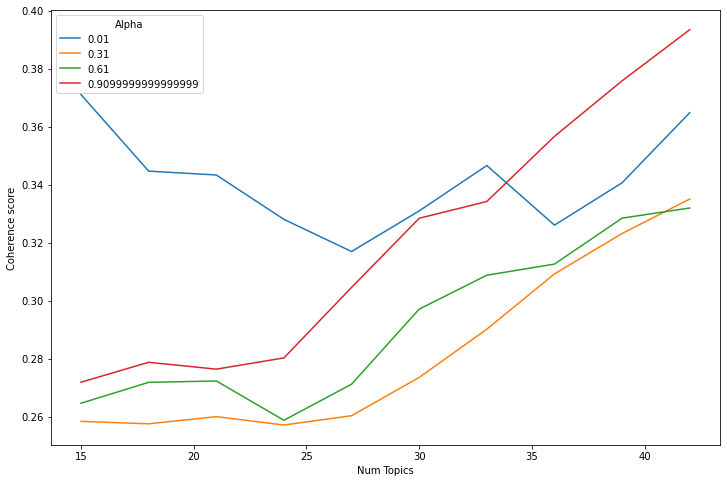

    Alpha  Num Topics  Coherence score
39   0.91          42         0.393391
38   0.91          39         0.375763
0    0.01          15         0.371017
9    0.01          42         0.364777
37   0.91          36         0.356620
6    0.01          33         0.346560
1    0.01          18         0.344640
2    0.01          21         0.343309
8    0.01          39         0.340620
19   0.31          42         0.335024


<Figure size 864x576 with 0 Axes>

In [10]:
plt.figure(figsize=(12, 8))
for current in result:
   plt.plot(topics_range, current['coherence_values'], label=current['alpha'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(title='Alpha', loc='best')
plt.show()

import pandas as pd

data = []

plt.figure(figsize=(12, 8))
for current in result:
    for index_num_topic, num_topic in enumerate(topics_range):
        data.append([current['alpha'], num_topic, current['coherence_values'][index_num_topic]])

df = pd.DataFrame(data,columns=['Alpha','Num Topics', 'Coherence score'])
df = df.sort_values(by='Coherence score', ascending=False)
print(df.head(10))

## Visualización de tópicos y palabras claves del modelo más óptimo

Se usa pyLDAvis para mostrar los tópicos y las palabras claves. Esta es una herramienta gráfico interactiva.

### Interpretación del gráfico:

Cada burbuja en el gráfico del lado izquierdo representa un tópico. Cuanto más grande es la burbuja, más frecuente es ese tópico. A la derecha del gráfico aparecen las palabras claves del tópico.


In [15]:
lda_model_result = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=42,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=0.01,
                                                  per_word_topics=True)

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_result, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
37     0.211930  0.030233       1        1  3.301197
28     0.092919 -0.094331       2        1  3.301081
9     -0.079647 -0.033388       3        1  3.125797
1     -0.198486 -0.082435       4        1  3.048414
19     0.061925 -0.151173       5        1  3.029138
12    -0.031850  0.037512       6        1  3.006104
15    -0.168140  0.017240       7        1  2.882107
36    -0.173766  0.102057       8        1  2.882012
20    -0.056124 -0.042598       9        1  2.792691
29     0.081409 -0.158274      10        1  2.787717
38    -0.042610  0.043041      11        1  2.643229
21     0.039909  0.152604      12        1  2.633172
0     -0.117635  0.050763      13        1  2.615428
17     0.085098 -0.064963      14        1  2.535417
26    -0.047266 -0.138086      15        1  2.508664
4     -0.135242  0.082127      16        1  2.501578
32    -0.043250 -0.128814      17        1  2.477780
30    -0.088682 -0.091229      18        1  2.447302
39     0.077386  0.107260      19        1  2.354015
2     -0.084350  0.008063      20        1  2.334237
11     0.094618  0.020494      21        1  2.306322
8     -0.045055  0.048597      22        1  2.272197
18     0.060522  0.113045      23        1  2.260437
13     0.111430 -0.050049      24        1  2.244047
6      0.016439  0.078997      25        1  2.188129
22    -0.059780 -0.136536      26        1  2.153232
5     -0.027249 -0.024913      27        1  2.136736
33     0.050297 -0.096943      28        1  2.130383
10     0.080463  0.054855      29        1  2.083731
23    -0.020597 -0.079561      30        1  2.081183
34     0.076647  0.084703      31        1  2.080964
40    -0.048778  0.130311      32        1  2.042196
25     0.052910  0.049753      33        1  2.033984
41    -0.001020  0.004499      34        1  2.012877
3      0.056275  0.096454      35        1  1.968466
14     0.115726  0.052308      36        1  1.955660
31    -0.054902 -0.121269      37        1  1.900802
35     0.053098  0.070105      38        1  1.871060
27    -0.162776  0.096810      39        1  1.819663
24     0.132503 -0.066457      40        1  1.796314
16     0.079188  0.067044      41        1  1.780351
7      0.056515 -0.037855      42        1  1.674186, topic_info=            Term         Freq        Total Category  logprob  loglift
3            ano  4132.000000  4132.000000  Default  30.0000  30.0000
88       cordoba  2902.000000  2902.000000  Default  29.0000  29.0000
600       millon  1826.000000  1826.000000  Default  28.0000  28.0000
363       ciudad  1400.000000  1400.000000  Default  27.0000  27.0000
669        pesos  1398.000000  1398.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
826         caja   109.466134   175.479079  Topic42  -3.8709   3.6179
1341  porcentaje    75.006509   145.930600  Topic42  -4.2489   3.4243
1387       crese    56.123030   169.216852  Topic42  -4.5389   2.9862
380     permitir    61.388119   557.915360  Topic42  -4.4493   1.8829
331     cordobes    40.662267   404.106859  Topic42  -4.8612   1.7935

[1544 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
796      32  0.992471       abierto
816       5  0.994221       abogado
1092     20  0.995882        aborto
386       5  0.157283         abril
386      19  0.834810         abril
...     ...       ...           ...
647      15  0.996594  voz_interior
980       7  0.990613        vuelta
883      16  0.993910        walter
1264     33  0.993834    washington
290      14  0.997672          zona

[2708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[38, 29, 10, 2, 20, 13, 16, 37, 21, 30, 39, 22, 1, 18, 27, 5, 33, 31, 40, 3, 12, 9, 19, 14, 7, 23, 6, 34, 11, 24, 35, 41, 26, 42, 4, 15, 32, 36, 28, 25, 17, 8])

In [17]:
for index, topic in lda_model_result.show_topics(num_topics=30, formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))


Topic: 11 
Words: ['comenzar', 'terminar', 'padre', 'hombre', 'hijo', 'iniciar', 'llamar', 'juan', 'declarar', 'recien', 'visita', 'detenido', 'coincidir', 'ayudar', 'plazo', 'extender', 'leer', 'critica', 'recuperar', 'suponer', 'liberacion', 'error', 'incrementar', 'maximo', 'pablo', 'pagina', 'esposa', 'mujer', 'marzo', 'aspecto']
Topic: 28 
Words: ['millon', 'pesos', 'dolares', 'pagar', 'ano', 'falta', 'banco', 'deuda', 'costo', 'pago', 'inversion', 'implicar', 'fabrica', 'provincia', 'cuota', 'energia', 'fondo', 'tasa', 'empresa', 'anual', 'enero', 'recaudacion', 'invertir', 'nacion', 'contrato', 'contenido', 'instalacion', 'subsidio', 'financiar', 'credito']
Topic: 34 
Words: ['cambio', 'planta', 'producir', 'firma', 'resto', 'rio_cuarto', 'mano', 'personal', 'razon', 'alla', 'demostrar', 'basura', 'instalar', 'mayo', 'positivo', 'analisis', 'formar', 'funcion', 'limite', 'cuba', 'bien', 'isla', 'concreto', 'generacion', 'exportar', 'adelantar', 'mundo', 'castro', 'unidos', 'vill

También podemos visualizar las palabras más importantes de cada tópico mediante nube de palabras, donde el tamaño de cada palabra corresponde con su contribución en el tópico.

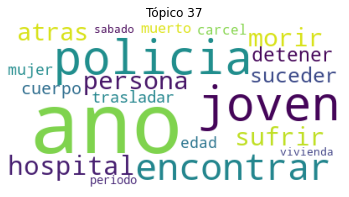

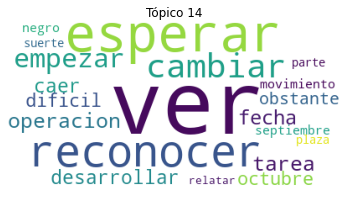

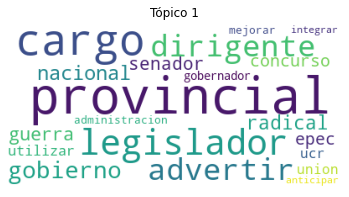

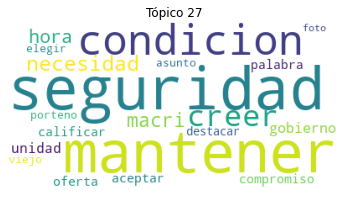

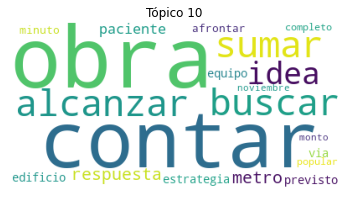

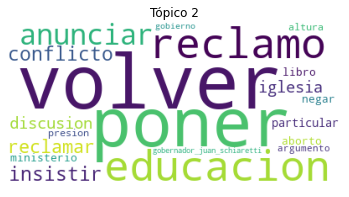

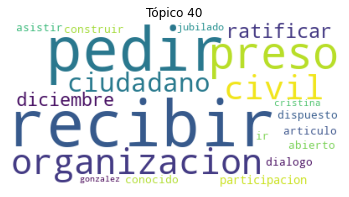

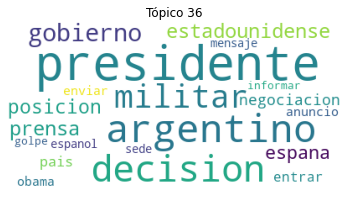

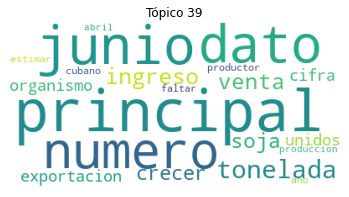

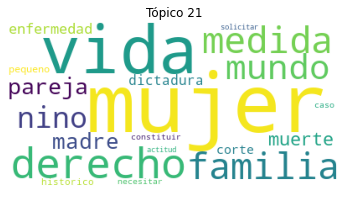

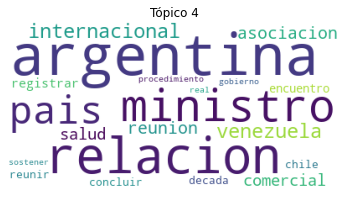

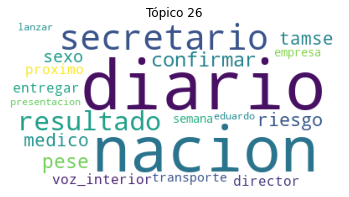

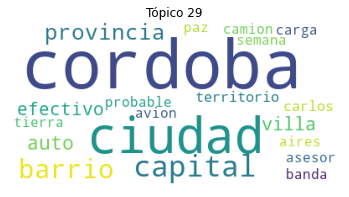

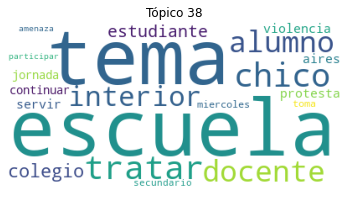

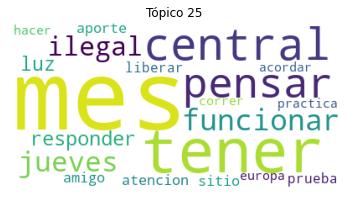

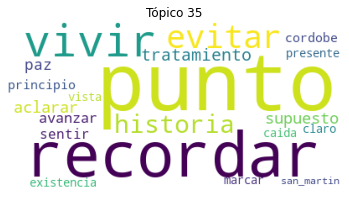

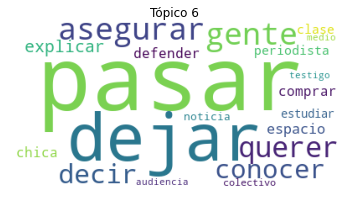

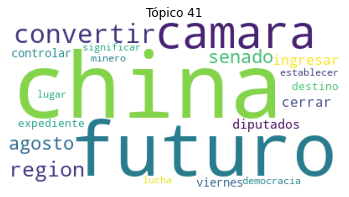

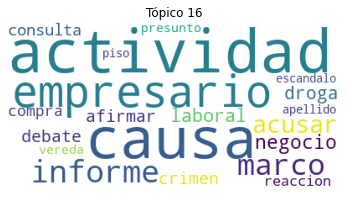

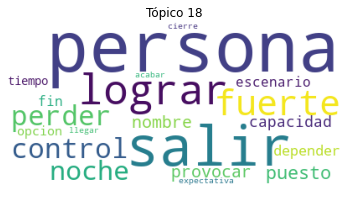

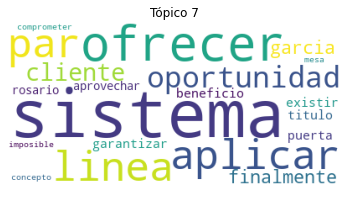

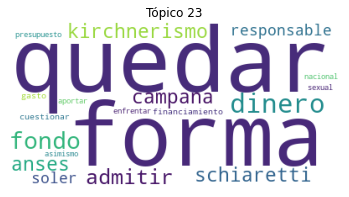

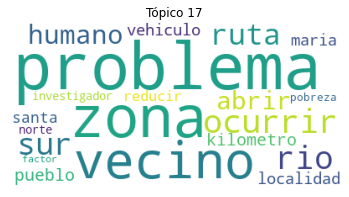

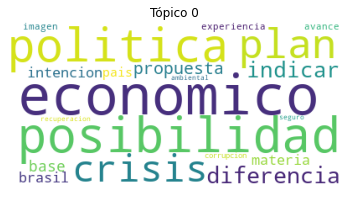

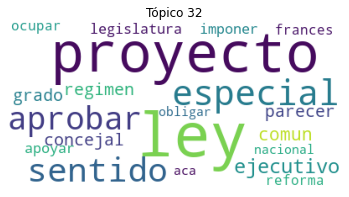

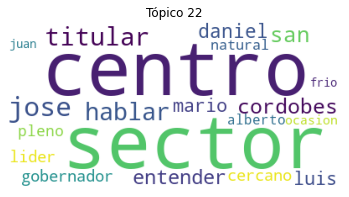

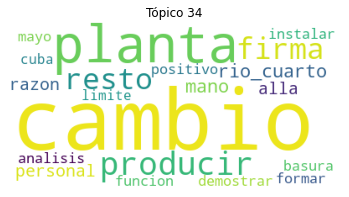

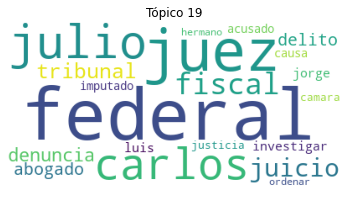

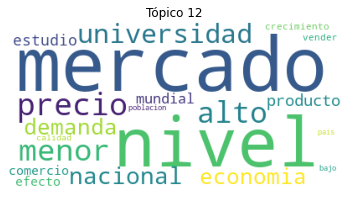

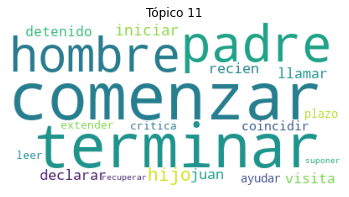

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for index, topic in lda_model_result.show_topics(num_topics=30, formatted=False, num_words= 30):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda_model_result.show_topic(index, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(index))
    plt.show()